In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


In [3]:
#other useful imports 
import os
import numpy as np
import scipy as sp
import scipy.stats as stats
import h5py

In [4]:

#let's import the SVM classifier
from sklearn.svm import LinearSVC

#our own internal utility unctions
import metrics ; reload(metrics)
import cross_validation as cv; reload(cv)
import utils; reload(utils)
from utils import featurewise_norm, spearman_brown


In [5]:
#ok let's load the neural data 
DATA_PATH = "/home/chengxuz/Class/psych253_2018/data/ventral_neural_data.hdf5"
Ventral_Dataset = h5py.File(DATA_PATH)

categories = Ventral_Dataset['image_meta']['category'][:]   #array of category labels for all images  --> shape == (5760,)
unique_categories = np.unique(categories)                #array of unique category labels --> shape == (8,)
objects = Ventral_Dataset['image_meta']['object_name'][:]   #array of object labels for all images --> shape == (5670,)
unique_objects = np.unique(objects)                      #array of unique object labels --> shape == (64,) 

objects_by_category = {c: np.unique(objects[categories == c]) 
                       for c in unique_categories}

Neural_Data = Ventral_Dataset['time_averaged_trial_averaged'][:]
IT_NEURONS = Ventral_Dataset['neural_meta']['IT_NEURONS']
V4_NEURONS = Ventral_Dataset['neural_meta']['V4_NEURONS']
V4_Neural_Data = Neural_Data[:, V4_NEURONS]
IT_Neural_Data = Neural_Data[:, IT_NEURONS]

var_level = Ventral_Dataset['image_meta']['variation_level'][:]

#use numpy recarray object to store metadata 
meta_array = np.core.records.fromarrays(Ventral_Dataset['image_meta'].values(),
                                        names=Ventral_Dataset['image_meta'].keys())

In [54]:
from sklearn.linear_model import LinearRegression, RidgeCV

### Estimating Rotation Per Category

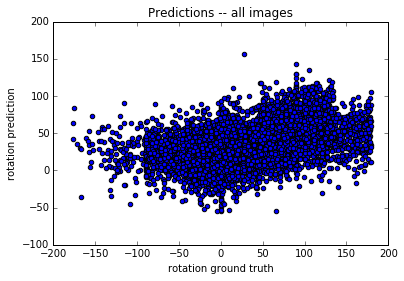

In [7]:
cls = LinearRegression()
rot_xy =  meta_array['rotation_xy']
cls.fit(IT_Neural_Data, rot_xy)
pred = cls.predict(IT_Neural_Data)
plt.scatter(rot_xy, pred)
plt.xlabel('rotation ground truth')
plt.ylabel('rotation prediction')
plt.title('Predictions -- all images')

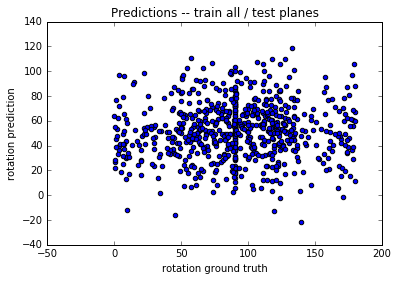

In [8]:
inds = meta_array['category'] == 'Planes'
pred_inds = pred[inds]
rot_xy_inds = rot_xy[inds]
plt.scatter(rot_xy_inds, pred_inds)
plt.xlabel('rotation ground truth')
plt.ylabel('rotation prediction')
plt.title('Predictions -- train all / test planes')

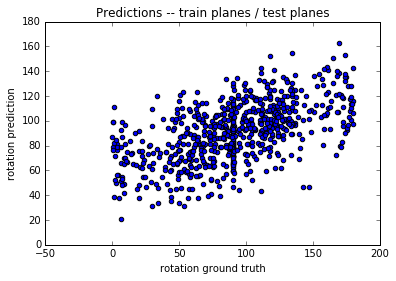

In [9]:
cls = LinearRegression()
rot_xy =  meta_array['rotation_xy']
cls.fit(IT_Neural_Data[inds], rot_xy[inds])
pred_sep_inds = cls.predict(IT_Neural_Data[inds])
plt.scatter(rot_xy_inds, pred_sep_inds)
plt.xlabel('rotation ground truth')
plt.ylabel('rotation prediction')
plt.title('Predictions -- train planes / test planes')

getting Animals
getting Boats
getting Cars
getting Chairs
getting Faces
getting Fruits
getting Planes
getting Tables


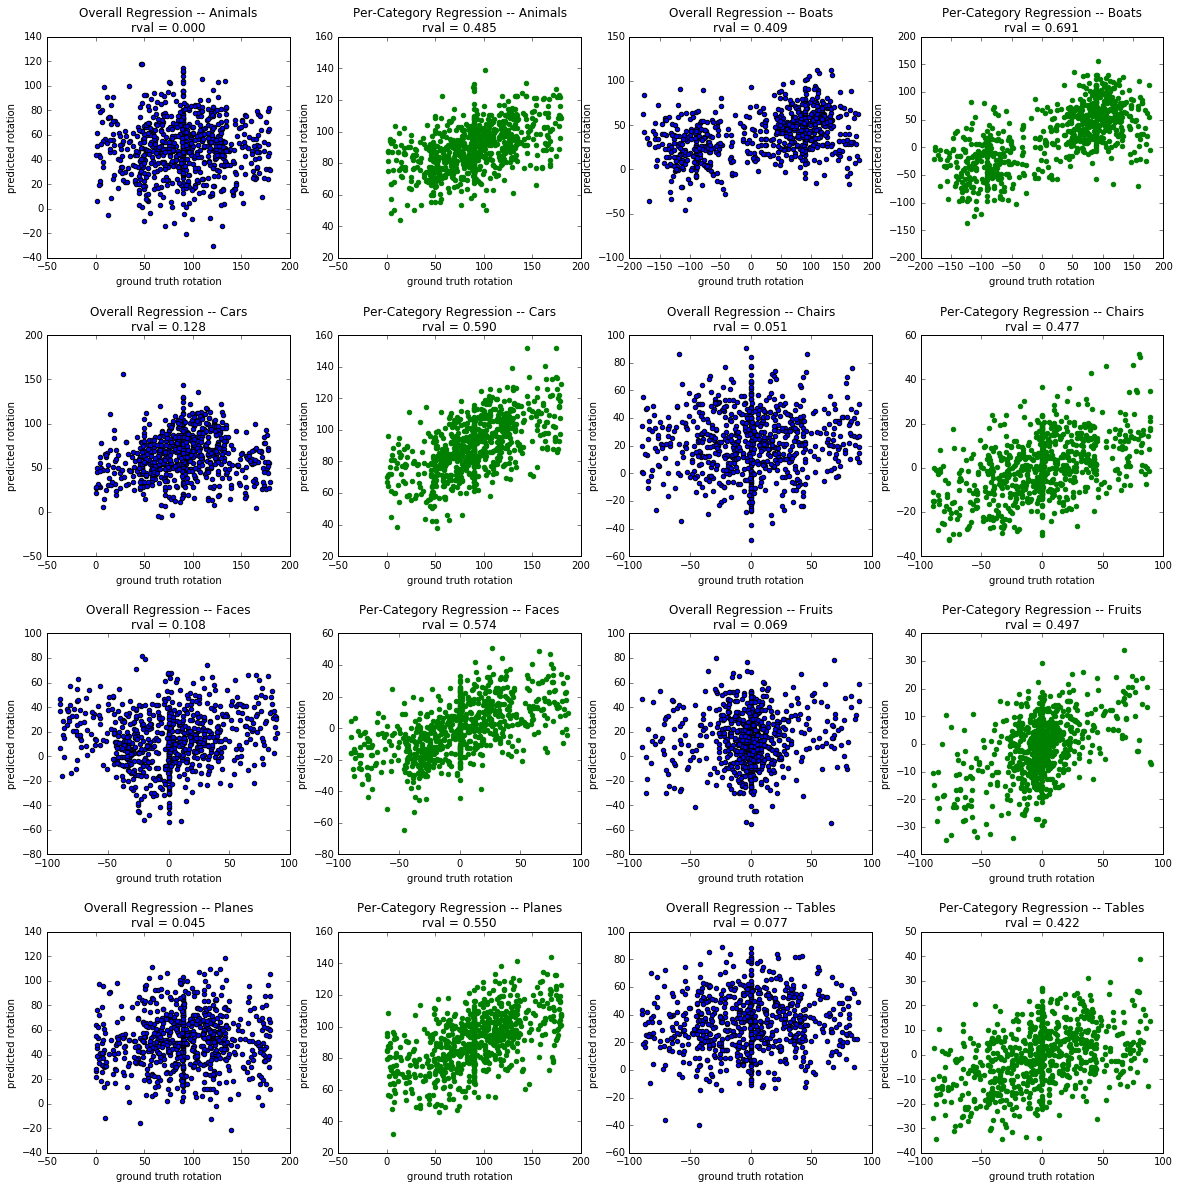

In [57]:
cls = LinearRegression()
rot_xy =  meta_array['rotation_xy']
cls.fit(IT_Neural_Data, rot_xy)
overall_preds = cls.predict(IT_Neural_Data)

plt.figure(figsize=(20, 20))
rot_preds_per_cat = {}
for cind, c in enumerate(unique_categories):
    print('getting %s' % c)
    inds = meta_array["category"] == c
    cls = RidgeCV()
    #cls = LinearRegression()
    cls.fit(IT_Neural_Data[inds], rot_xy[inds])
    pred_per_cat = cls.predict(IT_Neural_Data[inds])
    rot_preds_per_cat[c] = (pred_per_cat, overall_preds[inds], rot_xy[inds], cls) 
    
    plt.subplot(4, 4, 2*cind+1)
    rv1 = stats.pearsonr(rot_xy[inds], overall_preds[inds])[0]
    plt.scatter(rot_xy[inds], overall_preds[inds])
    plt.xlabel('ground truth rotation')
    plt.ylabel('predicted rotation')
    plt.title('Overall Regression -- %s\nrval = %.3f' % (c, rv1))
    plt.subplot(4, 4, 2*cind+2)
    plt.scatter(rot_xy[inds], pred_per_cat, color='g')
    rv2 = stats.pearsonr(rot_xy[inds], pred_per_cat)[0]
    plt.xlabel('ground truth rotation')
    plt.ylabel('predicted rotation')
    plt.title('Per-Category Regression -- %s\nrval = %.3f' % (c, rv2))
    
plt.subplots_adjust(hspace=0.35)

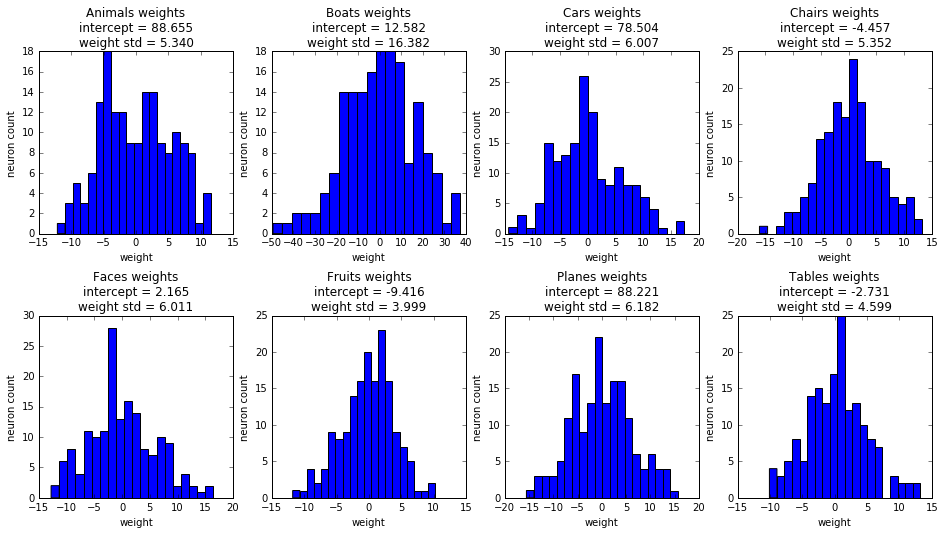

In [58]:
plt.figure(figsize=(16, 8))
for cind, c in enumerate(unique_categories):
    plt.subplot(2, 4, cind + 1)
    model = rot_preds_per_cat[c][-1]
    plt.hist(model.coef_, bins=20)
    stdval = model.coef_.std()
    plt.title('%s weights\nintercept = %.3f\nweight std = %.3f' % (c, model.intercept_, stdval))
    plt.xlabel('weight')
    plt.ylabel('neuron count')
    
plt.subplots_adjust(hspace=.45)

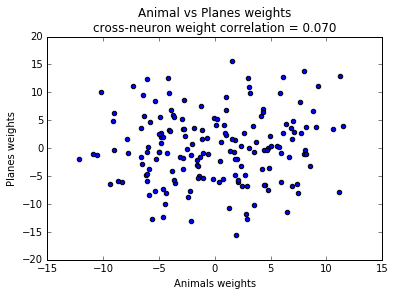

In [272]:
model1 = rot_preds_per_cat['Animals'][-1]
model2 = rot_preds_per_cat['Planes'][-1]

weights1 = model1.coef_
weights2 = model2.coef_

plt.scatter(weights1, weights2)
plt.xlabel('Animals weights')
plt.ylabel('Planes weights')
rval = stats.pearsonr(weights1, weights2)[0]
plt.title('Animal vs Planes weights\ncross-neuron weight correlation = %.3f' % rval)

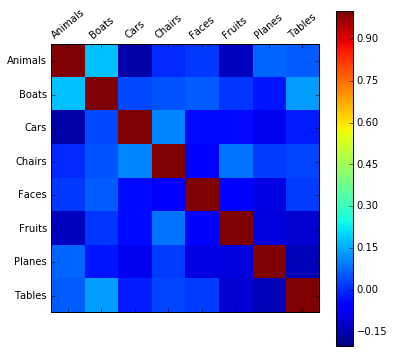

In [116]:
plt.figure(figsize=(6, 6))
r_array = np.zeros((8, 8))
for cind1, c1 in enumerate(unique_categories):
    for cind2, c2 in enumerate(unique_categories):
        model1 = rot_preds_per_cat[c1][-1]
        model2 = rot_preds_per_cat[c2][-1]
        rval = stats.pearsonr(model1.coef_, model2.coef_)[0]
        r_array[cind1, cind2] = rval
        
plot_out = plt.gca().matshow(r_array, vmin=-.2, vmax=1)
plt.colorbar(plot_out)
plt.xticks(np.arange(8), unique_categories, rotation=40);
plt.yticks(np.arange(8), unique_categories);


### Estimating Translation Per Category

getting Animals
getting Boats
getting Cars
getting Chairs
getting Faces
getting Fruits
getting Planes
getting Tables


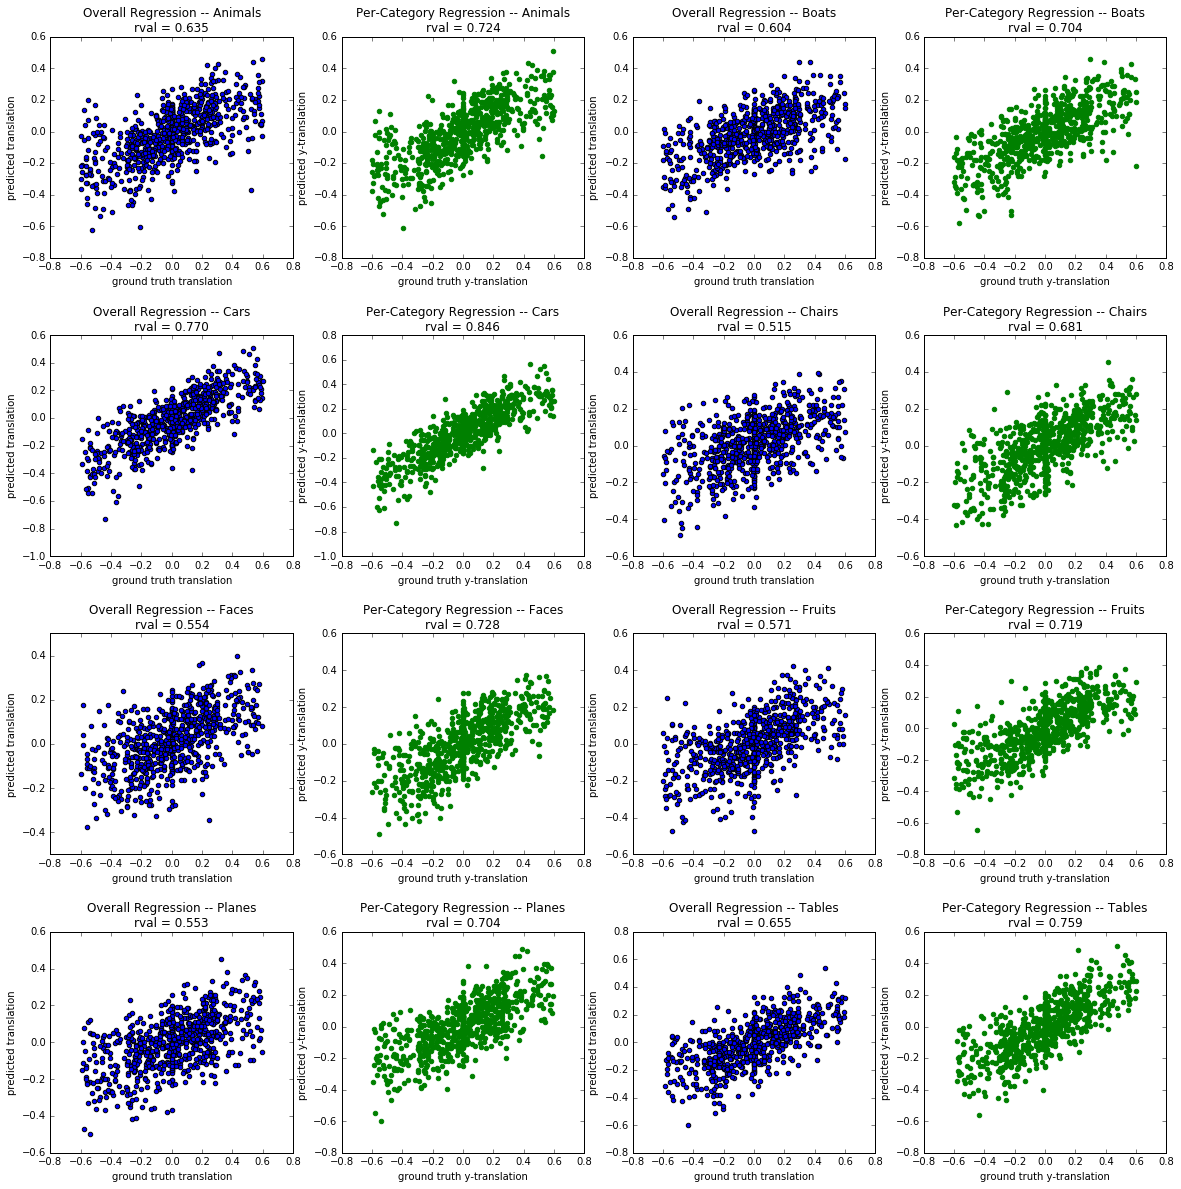

In [137]:
cls = RidgeCV()
trans_y =  meta_array['translation_y']
cls.fit(IT_Neural_Data, trans_y)
overall_preds = cls.predict(IT_Neural_Data)

plt.figure(figsize=(20, 20))
trans_preds_per_cat = {}
for cind, c in enumerate(unique_categories):
    print('getting %s' % c)
    inds = meta_array["category"] == c
    cls = RidgeCV()
    cls.fit(IT_Neural_Data[inds], trans_y[inds])
    pred_per_cat = cls.predict(IT_Neural_Data[inds])
    trans_preds_per_cat[c] = (pred_per_cat, overall_preds[inds], trans_y[inds], cls) 
    
    plt.subplot(4, 4, 2*cind+1)
    rv1 = stats.pearsonr(trans_y[inds], overall_preds[inds])[0]
    plt.scatter(trans_y[inds], overall_preds[inds])
    plt.xlabel('ground truth translation')
    plt.ylabel('predicted translation')
    plt.title('Overall Regression -- %s\nrval = %.3f' % (c, rv1))
    plt.subplot(4, 4, 2*cind+2)
    plt.scatter(trans_y[inds], pred_per_cat, color='g')
    rv2 = stats.pearsonr(trans_y[inds], pred_per_cat)[0]
    plt.xlabel('ground truth y-translation')
    plt.ylabel('predicted y-translation')
    plt.title('Per-Category Regression -- %s\nrval = %.3f' % (c, rv2))
    
plt.subplots_adjust(hspace=0.35)

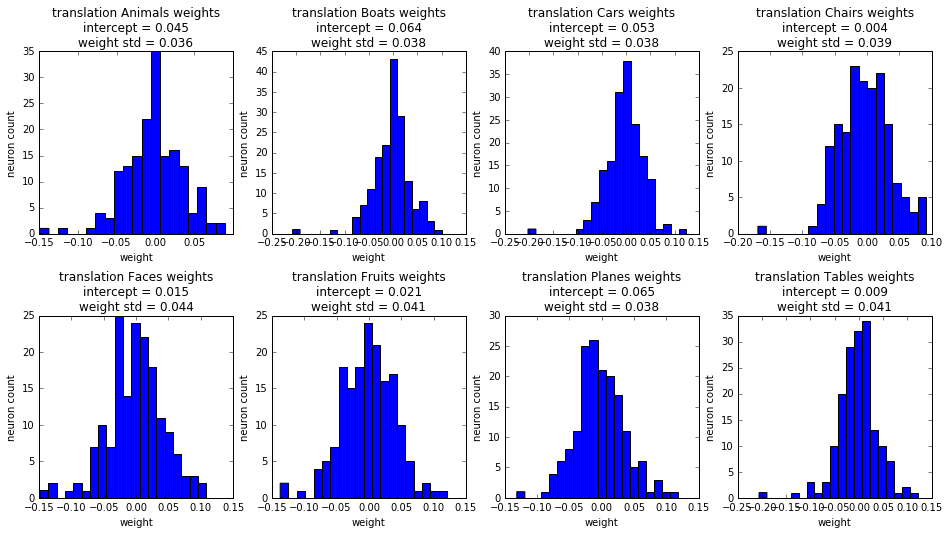

In [107]:
plt.figure(figsize=(16, 8))
for cind, c in enumerate(unique_categories):
    plt.subplot(2, 4, cind + 1)
    model = trans_preds_per_cat[c][-1]
    plt.hist(model.coef_, bins=20)
    stdval = model.coef_.std()
    plt.title('translation %s weights\nintercept = %.3f\nweight std = %.3f' % (c, model.intercept_, stdval))
    plt.xlabel('weight')
    plt.ylabel('neuron count')
    
plt.subplots_adjust(hspace=.45)

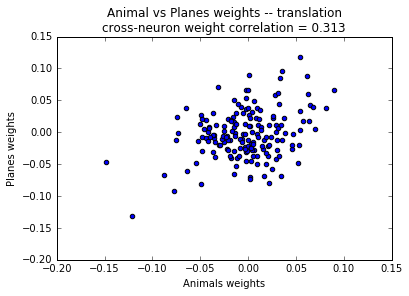

In [108]:
model1 = trans_preds_per_cat['Animals'][-1]
model2 = trans_preds_per_cat['Planes'][-1]

weights1 = model1.coef_
weights2 = model2.coef_

plt.scatter(weights1, weights2)
plt.xlabel('Animals weights')
plt.ylabel('Planes weights')
rval = stats.pearsonr(weights1, weights2)[0]
plt.title('Animal vs Planes weights -- translation\ncross-neuron weight correlation = %.3f' % rval)

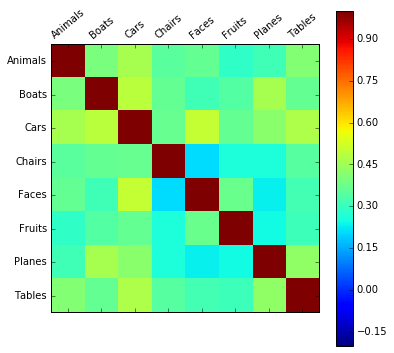

In [113]:
plt.figure(figsize=(6, 6))
r_array = np.zeros((8, 8))
for cind1, c1 in enumerate(unique_categories):
    for cind2, c2 in enumerate(unique_categories):
        model1 = trans_preds_per_cat[c1][-1]
        model2 = trans_preds_per_cat[c2][-1]
        rval = stats.pearsonr(model1.coef_, model2.coef_)[0]
        r_array[cind1, cind2] = rval
        
plot_out = plt.gca().matshow(r_array, vmin=-0.2, vmax=1)
plt.colorbar(plot_out)
plt.xticks(np.arange(8), unique_categories, rotation=40);
plt.yticks(np.arange(8), unique_categories);


### Estimating A Neuron Per Category

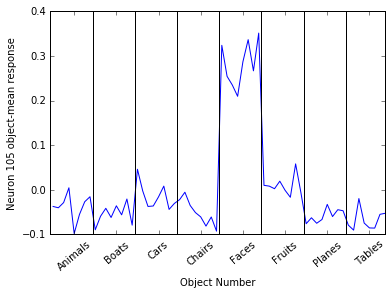

In [139]:
nind = 105
nd = IT_Neural_Data[:, nind]
sorted_nd = [nd[meta_array['object_name'] == o].mean() for c in unique_categories for o in objects_by_category[c] ]
plt.plot(sorted_nd)
plt.xlabel('Object Number')
plt.ylabel('Neuron %d object-mean response' % nind)
plt.xticks(np.arange(8)*8+4, unique_categories, rotation=40)
[plt.axvline(xv, color='k') for xv in np.arange(8)*8 - 0.5]

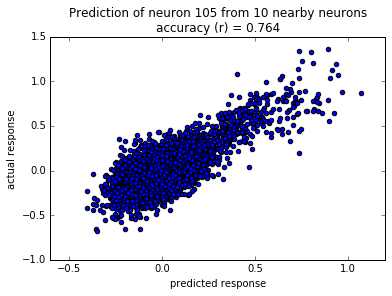

In [140]:
alphalist = [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
cls_overall = RidgeCV(alphas=alphalist)
pred_neurons = [100, 101, 102, 103, 104, 106, 107, 108, 109, 110]
nind = 105
nd = IT_Neural_Data[:, nind]
nd1 = IT_Neural_Data[:, pred_neurons]
cls_overall.fit(nd1, nd)
overall_preds = cls_overall.predict(nd1)
plt.scatter(overall_preds, nd)
plt.xlabel('predicted response')
plt.ylabel('actual response')
rval = stats.pearsonr(overall_preds, nd)[0]
plt.title('Prediction of neuron %d from %d nearby neurons\naccuracy (r) = %.3f' % (nind, len(pred_neurons), rval))

getting Animals
getting Boats
getting Cars
getting Chairs
getting Faces
getting Fruits
getting Planes
getting Tables


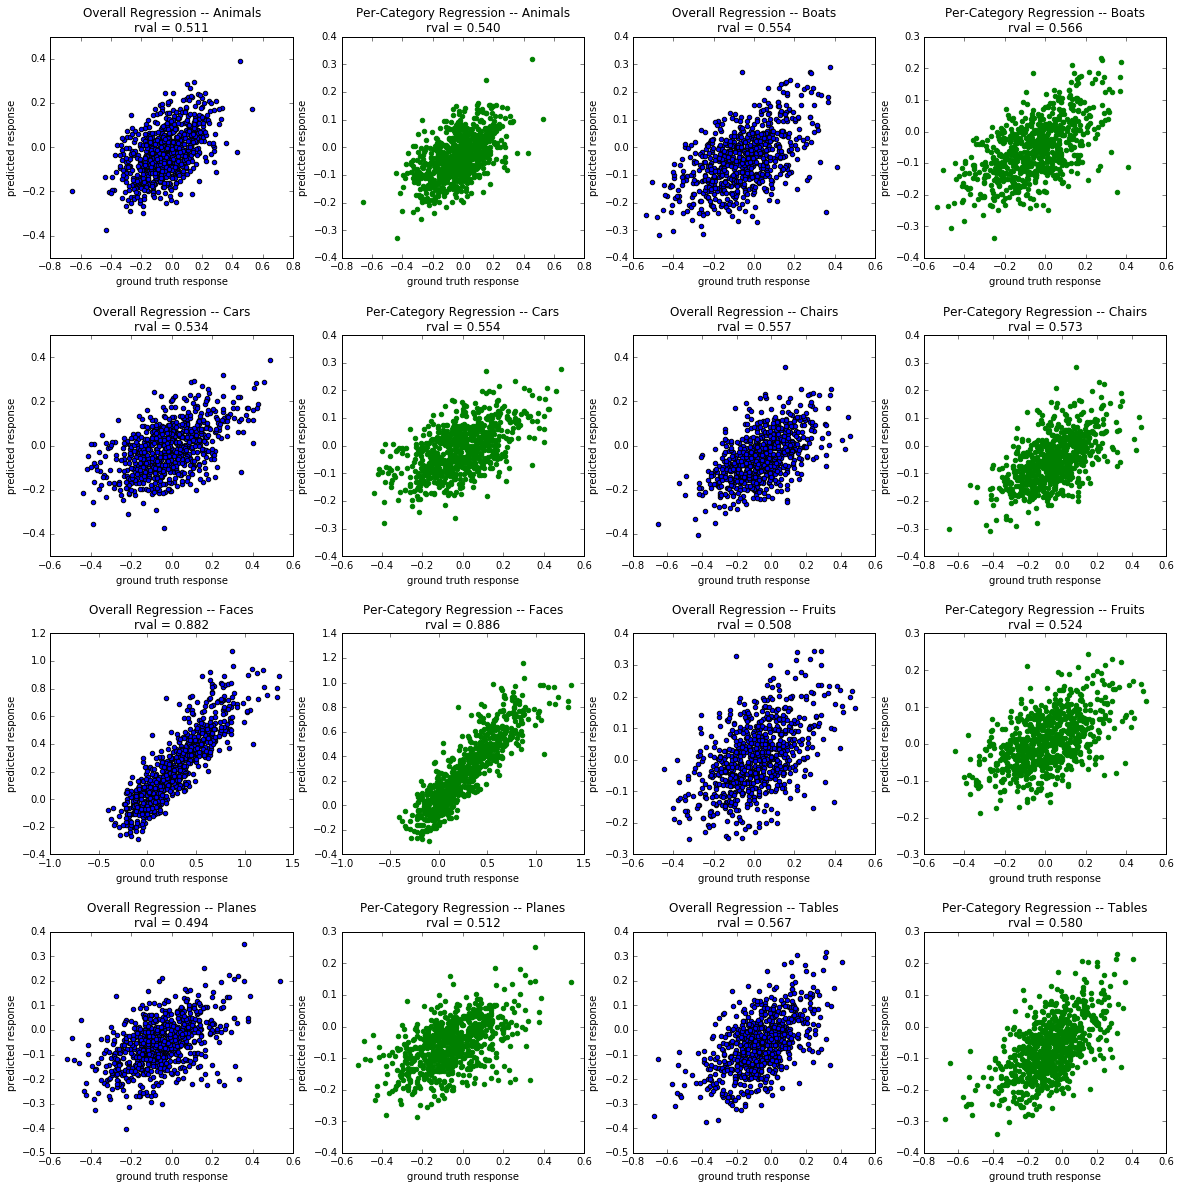

In [142]:
plt.figure(figsize=(20, 20))
neuron_preds_per_cat = {}
for cind, c in enumerate(unique_categories):
    print('getting %s' % c)
    inds = meta_array["category"] == c
    cls = RidgeCV(alphas = alphalist)
    cls.fit(nd1[inds], nd[inds])
    pred_per_cat = cls.predict(nd1[inds])
    neuron_preds_per_cat[c] = (pred_per_cat, overall_preds[inds], nd[inds], cls) 
    
    plt.subplot(4, 4, 2*cind+1)
    rv1 = stats.pearsonr(nd[inds], overall_preds[inds])[0]
    plt.scatter(nd[inds], overall_preds[inds])
    plt.xlabel('ground truth response')
    plt.ylabel('predicted response')
    plt.title('Overall Regression -- %s\nrval = %.3f' % (c, rv1))
    plt.subplot(4, 4, 2*cind+2)
    plt.scatter(nd[inds], pred_per_cat, color='g')
    rv2 = stats.pearsonr(nd[inds], pred_per_cat)[0]
    plt.xlabel('ground truth response')
    plt.ylabel('predicted response')
    plt.title('Per-Category Regression -- %s\nrval = %.3f' % (c, rv2))
    
plt.subplots_adjust(hspace=0.35)

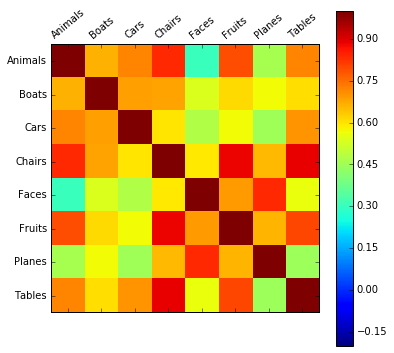

In [143]:
plt.figure(figsize=(6, 6))
r_array = np.zeros((8, 8))
for cind1, c1 in enumerate(unique_categories):
    for cind2, c2 in enumerate(unique_categories):
        model1 = neuron_preds_per_cat[c1][-1]
        model2 = neuron_preds_per_cat[c2][-1]
        rval = stats.pearsonr(model1.coef_, model2.coef_)[0]
        r_array[cind1, cind2] = rval
        
plot_out = plt.gca().matshow(r_array, vmin=-0.2, vmax=1)
plt.colorbar(plot_out)
plt.xticks(np.arange(8), unique_categories, rotation=40);
plt.yticks(np.arange(8), unique_categories);


#### adding categorical predictors

In [170]:
def binarizer(x, c):
    n = np.zeros((len(x), len(c)))
    for i, cv in enumerate(c):
        n[x == cv, i] = 1
    return n

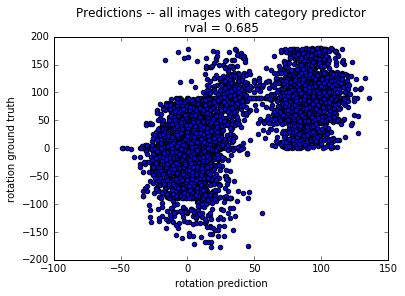

In [273]:
cls = LinearRegression()
rot_xy =  meta_array['rotation_xy']
binarized_categories = binarizer(meta_array['category'], unique_categories)
extended_data = np.column_stack([IT_Neural_Data, binarized_categories])
cls.fit(extended_data, rot_xy)
overall_preds = cls.predict(extended_data)
plt.scatter(overall_preds, rot_xy)
plt.xlabel('rotation prediction')
plt.ylabel('rotation ground truth')
rval = stats.pearsonr(overall_preds, rot_xy)[0]
plt.title('Predictions -- all images with category predictor\nrval = %.3f' % rval)

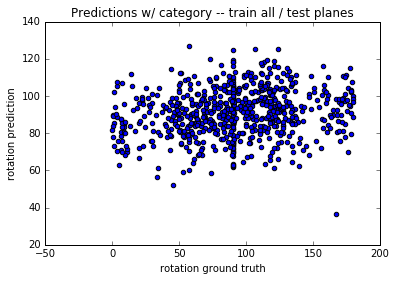

In [274]:
inds = meta_array['category'] == 'Planes'
pred_inds = overall_preds[inds]
rot_xy_inds = rot_xy[inds]
plt.scatter(rot_xy_inds, pred_inds)
plt.xlabel('rotation ground truth')
plt.ylabel('rotation prediction')
plt.title('Predictions w/ category -- train all / test planes')

### Student / Teacher Dataset

In [11]:
ls /mnt/data3/yamins/skdata_home/edward_data

InstEval.csv


In [154]:
import pandas as pd   #this is a python package for tabular data handling


In [155]:
#data from the lme4 package -- https://www.rdocumentation.org/packages/lme4/versions/1.1-21/topics/InstEval
#It's a data set of instructor evaluation ratings, where inputs include
#categories such as sstudents and departments and response variable of interest
# is the instructor evaluation rating
from observations import insteval

#loading the data from csv
data_path = os.path.join(os.environ["SKDATA_ROOT"], "edward_data")
data, metadata = insteval(data_path)

#putting the data into pandas
data = pd.DataFrame(data, columns=metadata['columns'])


In [13]:
#s = individual student
#d = individual lecturer
#studage = student's age in semester number
#lectage = time since class was given
#service = binary (is the class in lecturer's home department)
#dept = which depeartment
#y = numerical rating value
data


,s,d,studage,lectage,service,dept,y
0,1,1002,2,2,0,2,5
1,1,1050,2,1,1,6,2
2,1,1582,2,2,0,2,5
3,1,2050,2,2,1,3,3
4,2,115,2,1,0,5,2
5,2,756,2,1,0,5,4
6,3,7,2,1,1,11,4
7,3,13,2,1,0,10,5
8,3,36,2,1,0,10,5
9,3,140,2,1,0,10,4


In [156]:
#giving ourselves access to various R objects
import rpy2.robjects as robjects

In [15]:
dir(robjects)

['Array',
 'BoolVector',
 'ComplexVector',
 'DataFrame',
 'DateVector',
 'Environment',
 'FactorVector',
 'FloatVector',
 'Formula',
 'Function',
 'IntVector',
 'ListVector',
 'Matrix',
 'NA_Character',
 'NA_Complex',
 'NA_Integer',
 'NA_Logical',
 'NA_Real',
 'NULL',
 'POSIXct',
 'POSIXlt',
 'ParsedCode',
 'R',
 'RObject',
 'RObjectMixin',
 'RS4',
 'Sexp',
 'SexpClosure',
 'SexpEnvironment',
 'SexpExtPtr',
 'SexpS4',
 'SexpVector',
 'SignatureTranslatedFunction',
 'SourceCode',
 'StrSexpVector',
 'StrVector',
 'TYPEORDER',
 'Vector',
 '_',
 '__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 '__path__',
 '_function_to_ri',
 '_globalenv',
 '_reval',
 '_rparse',
 'array',
 'baseenv',
 'conversion',
 'datetime',
 'default_converter',
 'default_py2ri',
 'emptyenv',
 'environments',
 'functions',
 'globalenv',
 'help',
 'int2ri',
 'itertools',
 'methods',
 'os',
 'packages_utils',
 'py3bytes',
 'py3str',
 'r',
 'reval',
 'rinterface',
 'rlc',
 'robject',
 'sequence_to_ve

In [157]:
#to let rpy2 know that you want it to interpret "data" inputs from python
#to R in the "pandas" form
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

In [158]:
#the resid function (creates residual vector on training data)
resid = robjects.r['resid']

In [159]:
resid

R object with classes: ('function',) mapped to:
<SignatureTranslatedFunction - Python:0x7fd7e0bd6bd8 / R:0xb32ed20>

In [219]:
#here's the linear model object
lm = robjects.r['lm']
lm

R object with classes: ('function',) mapped to:
<SignatureTranslatedFunction - Python:0x7fd7e01b8f38 / R:0xab15af0>

In [264]:
#let's create a model of the form
#   rating = alpha + beta * service
formula_basic = 'y ~ 1 + service'
m_basic = lm(formula=formula_basic, data=data)

In [265]:
#how to access data about the trained R model in python
np.asarray(m_basic[0])

array([ 3.26223642, -0.13049933])

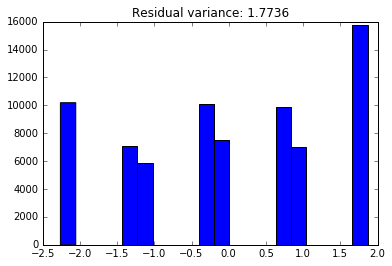

In [266]:
#call the residual function on the trained model 
resid_vec = np.asarray(resid(m_basic))

plt.hist(resid_vec, bins=20);
plt.title('Residual variance: %.4f' % resid_vec.var())

In [225]:
r_predict = robjects.r.predict

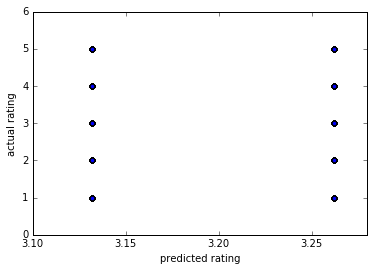

In [267]:
preds = np.asarray(r_predict(m_basic, data=data))
plt.scatter(preds, data['y'])
plt.xlabel('predicted rating')
plt.ylabel('actual rating')

In [235]:
def plot_rating_model(model, formula):
    resid_vec = np.asarray(resid(model))
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(resid_vec);
    plt.title('Residual variance: %.4f' % resid_vec.var())
    plt.subplot(1, 2, 2)
    preds = np.asarray(r_predict(model, data=data))
    plt.scatter(preds, data['y'])
    plt.xlabel('predicted rating')
    plt.ylabel('actual rating')
    plt.title(formula)

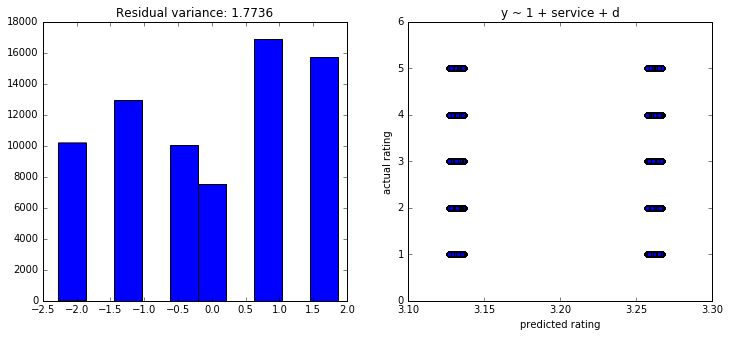

In [236]:
formula = 'y ~ 1 + service + d'
m_more = lm(formula=formula, data=data)
plot_rating_model(m_more, formula)

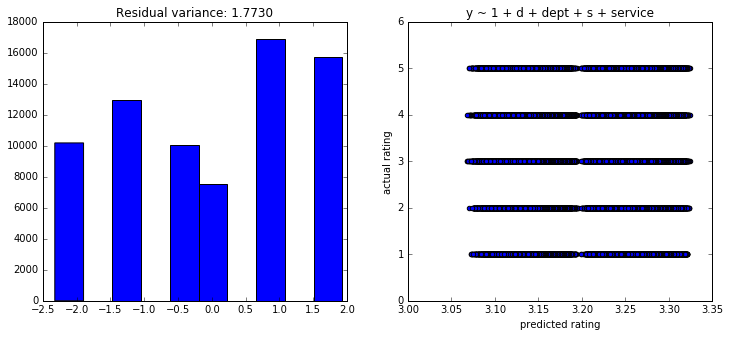

In [237]:
formula = 'y ~ 1 + d + dept + s + service'
m_all = lm(formula=formula, data=data)
plot_rating_model(m_all, formula)

### lmer

In [162]:
from rpy2.robjects.packages import importr
lme4 = importr('lme4')

In [27]:
lme4

rpy2.robjects.packages.Package as a <module 'lme4' (built-in)>

In [28]:
dir(lme4)

['Cv_to_Sv',
 'Cv_to_Vv',
 'Eigen_SSE',
 'GHrule',
 'GQN',
 'GQdk',
 'Gamma_simfun',
 'NelderMead',
 'NelderMead_Create',
 'NelderMead_newf',
 'NelderMead_setForce_stop',
 'NelderMead_setFtol_abs',
 'NelderMead_setFtol_rel',
 'NelderMead_setIprint',
 'NelderMead_setMaxeval',
 'NelderMead_setMinf_max',
 'NelderMead_value',
 'NelderMead_xeval',
 'NelderMead_xpos',
 'Nelder_Mead',
 'REMLcrit',
 'RHSForm',
 'RHSForm<-',
 'RglmerWrkIter',
 'Sv_to_Cv',
 'VarCorr_merMod',
 'Vv_to_Cv',
 '_S3MethodsClasses',
 '___C__NelderMead',
 '___C__family',
 '___C__glmFamily',
 '___C__glmResp',
 '___C__glmerMod',
 '___C__golden',
 '___C__lmList4',
 '___C__lmList4_confint',
 '___C__lmResp',
 '___C__lmerMod',
 '___C__lmerResp',
 '___C__merMod',
 '___C__merPredD',
 '___C__nlmerMod',
 '___C__nlsResp',
 '___C__rePos',
 '___C__vcRep',
 '___NAMESPACE___',
 '___S3MethodsTable___',
 '___T__getL:lme4',
 '___T__show:methods',
 '___global__',
 '___suppressForeign__',
 '__doc__',
 '__name__',
 '__rdata__',
 '__rname__'

In [29]:
lme4.lmer

R object with classes: ('function',) mapped to:
<DocumentedSTFunction - Python:0x7f37dcbe4c20 / R:0xc9a94a0>

In [30]:
lme4.lmer.__rname__

'lmer'

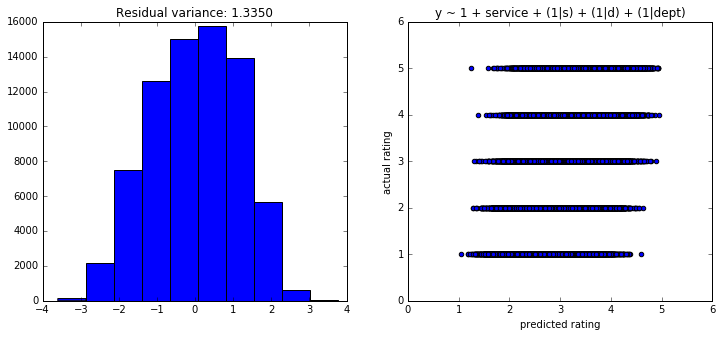

In [258]:
formula1 = 'y ~ 1 + service + (1|s) + (1|d) + (1|dept)'
m1 = lme4.lmer(formula=formula1, data=data)
plot_rating_model(m1, formula1)


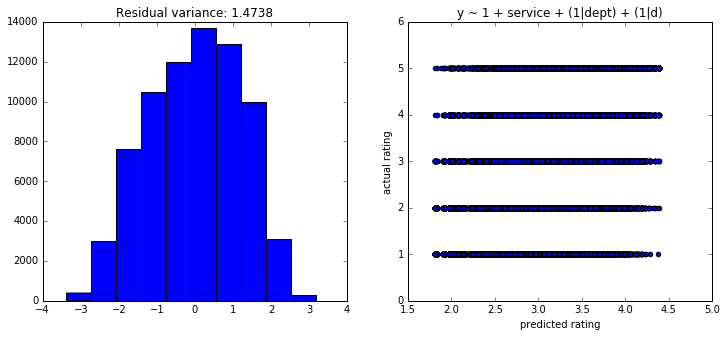

In [240]:
formula2 = 'y ~ 1 + service + (1|dept) + (1|d)'
m2 = lme4.lmer(formula=formula2, data=data)
plot_rating_model(m2, formula2)

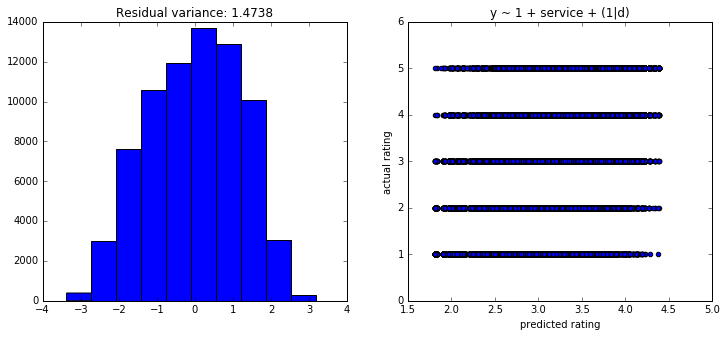

In [241]:
formula3 = 'y ~ 1 + service + (1|d)'
m3 = lme4.lmer(formula=formula3, data=data)
plot_rating_model(m3, formula3)

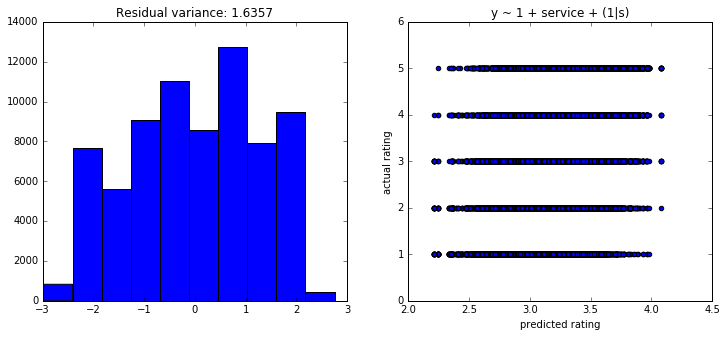

In [242]:
formula4 = 'y ~ 1 + service + (1|s)'
m4 = lme4.lmer(formula=formula4, data=data)
plot_rating_model(m4, formula4)

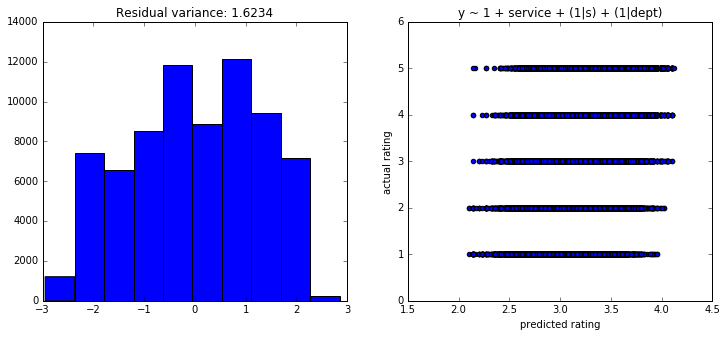

In [243]:
formula5 = 'y ~ 1 + service + (1|s) + (1|dept)'
m5 = lme4.lmer(formula=formula5, data=data)
plot_rating_model(m5, formula5)

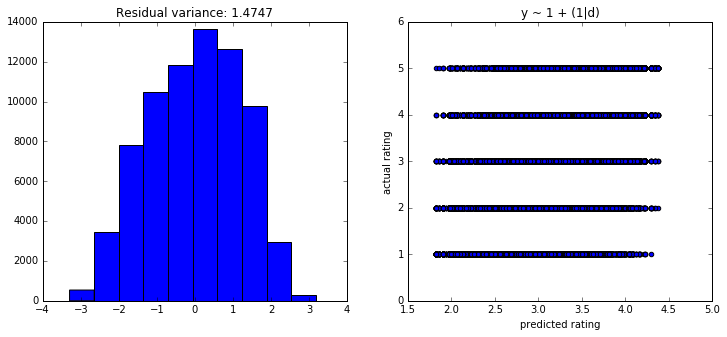

In [244]:
formula6 = 'y ~ 1 + (1|d)'
m6 = lme4.lmer(formula=formula6, data=data)
plot_rating_model(m6, formula6)

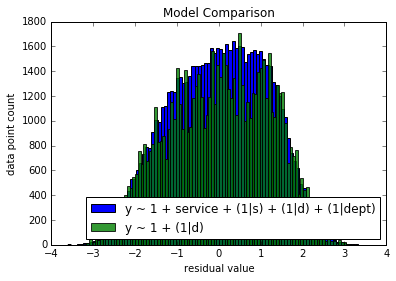

In [271]:
h1 = plt.hist(resid(m1), bins=100);
h6 = plt.hist(resid(m6), bins=100, alpha=.8);
plt.xlabel('residual value')
plt.ylabel('data point count')
plt.title('Model Comparison')
plt.legend([formula1, formula6], loc = 'lower right')

### Back to Neural Dataset

In [148]:
data_dict = {'n%d' % d : Neural_Data[:, d] for d in range(Neural_Data.shape[1])}
data_dict.update({k: meta_array[k] for k in meta_array.dtype.names})

neural_data_frame = pd.DataFrame.from_dict(data_dict)

In [149]:
data_dict['n32'].shape

(5760,)

In [150]:
neural_data_frame

,category,image_id,n0,n1,n10,n100,n101,n102,n103,n104,...,n98,n99,object_name,rotation_xy,rotation_xz,rotation_yz,size,translation_y,translation_z,variation_level
0,Fruits,f1ae7c2160c6cbb309b940a0dc127a8aa1060e5d,-0.081081,-0.209962,0.901115,-0.139349,0.168235,0.016626,-0.906583,-0.127227,...,0.028204,-0.528476,Apple_Fruit_obj,-0.000,0.000,-0.000,0.81000,0.000,0.000,V0
1,Fruits,691384450355c07ad084613a08a018ae8e1eebb2,-0.363256,-0.568020,0.732414,-0.174250,-0.376577,-0.034865,-0.933770,-0.211957,...,-0.133206,-0.059389,Apple_Fruit_obj,-0.000,0.000,-0.000,0.81000,0.000,0.000,V0
2,Fruits,fe9cd029e43ebdeeb509b61db1573a8286d06e6a,0.253764,0.045827,1.108896,-0.104079,0.389491,-0.036778,-0.685468,-0.309851,...,0.228667,-0.213073,Apple_Fruit_obj,-0.000,0.000,-0.000,0.81000,0.000,0.000,V0
3,Fruits,c766632574f6d86f0a048f2e5817826c1888699b,-0.247957,-0.086242,0.757311,0.224125,0.005139,0.088731,-0.959194,-0.186782,...,0.010468,-0.484144,Apple_Fruit_obj,-0.000,0.000,-0.000,0.81000,0.000,0.000,V0
4,Fruits,7edd311b0ef7a9e61c62c6cbc2b3cfc2b5b6ea9d,-0.127980,0.430337,0.567268,-0.110947,0.160423,-0.185895,-0.931280,-0.579234,...,0.017649,-0.571789,Apple_Fruit_obj,-0.000,0.000,-0.000,0.81000,0.000,0.000,V0
5,Fruits,3a2e8aeaae50f81d1d4fc716969bd2c8e169b9d9,0.395413,-0.002292,1.363421,0.600713,0.003640,-0.191785,-0.831739,-0.150296,...,-0.173640,-0.144068,Apple_Fruit_obj,-0.000,0.000,-0.000,0.81000,0.000,0.000,V0
6,Fruits,5cde85cc63e677623c606ebf6d21a6b028b50baf,0.001503,-0.050838,0.710564,-0.198979,-0.101293,-0.624726,-1.153886,-0.647177,...,-0.259504,-0.165058,Apple_Fruit_obj,-0.000,0.000,-0.000,0.81000,0.000,0.000,V0
7,Fruits,7cc53b502f4edb4c80316733868a33894016aa53,-0.394901,0.296192,0.391435,0.322888,-0.222100,0.174637,-0.894937,-0.280159,...,-0.256051,-0.192795,Apple_Fruit_obj,-0.000,0.000,-0.000,0.81000,0.000,0.000,V0
8,Fruits,c01fd13e140ad955d7ce56c365f6c0d850c0abbb,-0.250520,0.178697,1.062965,0.274795,-0.040394,-0.040905,-0.912897,-0.325346,...,0.087128,-0.467892,Apple_Fruit_obj,-0.000,0.000,-0.000,0.81000,0.000,0.000,V0
9,Fruits,202e13540b85d535b6fcabe430647ec11dcc67a5,-0.124786,-0.171695,0.669919,0.323930,-0.331210,0.097460,-0.810017,-0.458646,...,0.098857,-0.397827,Apple_Fruit_obj,-0.000,0.000,-0.000,0.81000,0.000,0.000,V0


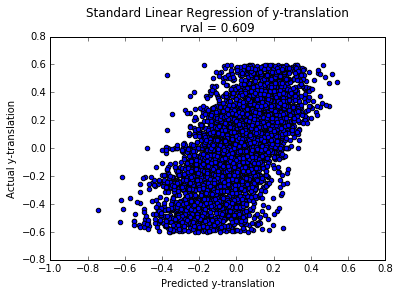

In [195]:
formula = 'translation_y ~ ' + ' + '.join(['n%d' % d for d in IT_NEURONS]) + ' + 1'
res = lm(formula=formula, data=neural_data_frame)
preds = np.asarray(robjects.r.predict(res, data=neural_data_frame))
plt.scatter(preds, meta_array['translation_y'])
plt.xlabel('Predicted y-translation')
plt.ylabel('Actual y-translation')
rval = stats.pearsonr(preds, meta_array['translation_y'])[0]
plt.title('Standard Linear Regression of y-translation\nrval = %.3f' % rval)

#### translation estimation

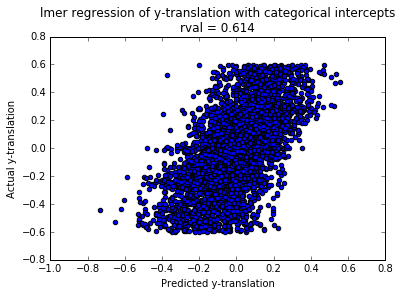

In [194]:
formula = 'translation_y ~ ' + ' + '.join(['n%d' % d for d in IT_NEURONS]) + ' + (1|category)'
res = lme4.lmer(formula=formula, data=neural_data_frame)
preds = np.asarray(robjects.r.predict(res, data=neural_data_frame))
plt.scatter(preds, meta_array['translation_y'])
plt.xlabel('Predicted y-translation')
plt.ylabel('Actual y-translation')
rval = stats.pearsonr(preds, meta_array['translation_y'])[0]
plt.title('lmer regression of y-translation with categorical intercepts\nrval = %.3f' % rval)

#### rotation estimation

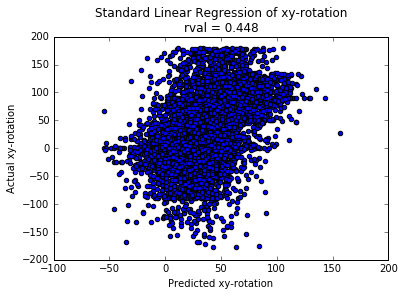

In [193]:
formula = 'rotation_xy ~ ' + ' + '.join(['n%d' % d for d in IT_NEURONS]) + ' + 1'
res = lm(formula=formula, data=neural_data_frame)
preds = np.asarray(robjects.r.predict(res, data=neural_data_frame))
plt.scatter(preds, meta_array['rotation_xy'])
plt.xlabel('Predicted xy-rotation')
plt.ylabel('Actual xy-rotation')
rval = stats.pearsonr(preds, meta_array['rotation_xy'])[0]
plt.title('Standard Linear Regression of xy-rotation\nrval = %.3f' % rval)

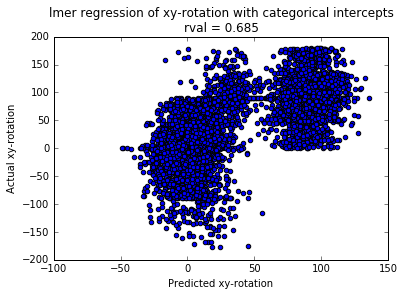

In [192]:
formula = 'rotation_xy ~ ' + ' + '.join(['n%d' % d for d in IT_NEURONS]) + ' + (1 | category)'
res = lme4.lmer(formula=formula, data=neural_data_frame)
preds = np.asarray(robjects.r.predict(res, data=neural_data_frame))
plt.scatter(preds, meta_array['rotation_xy'])
plt.xlabel('Predicted xy-rotation')
plt.ylabel('Actual xy-rotation')
rval = stats.pearsonr(preds, meta_array['rotation_xy'])[0]
plt.title('lmer regression of xy-rotation with categorical intercepts\nrval = %.3f' % rval)

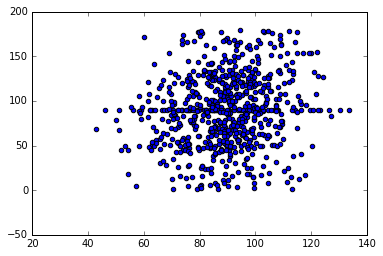

In [168]:
inds = meta_array['category'] == 'Animals'
plt.scatter(preds[inds], meta_array['rotation_xy'][inds])

#### neural estimation

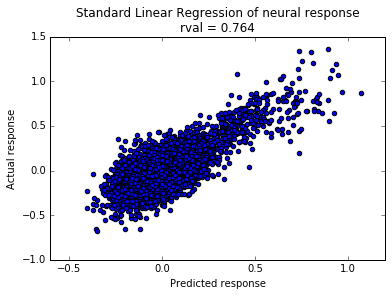

In [186]:
num = IT_NEURONS[:][105]
nd = Neural_Data[:, num]
pred_nums = [IT_NEURONS[:][k] for k in pred_neurons]

formula = ('n%d ~ 1 + ' % num) + ' + '.join(['n%d' % d for d in pred_nums])
res = lm(formula=formula, data=neural_data_frame)
preds = np.asarray(robjects.r.predict(res, data=neural_data_frame))
plt.scatter(preds, nd)
plt.xlabel('Predicted response')
plt.ylabel('Actual response')
rval = stats.pearsonr(preds, nd)[0]
plt.title('Standard Linear Regression of neural response\nrval = %.3f' % rval)

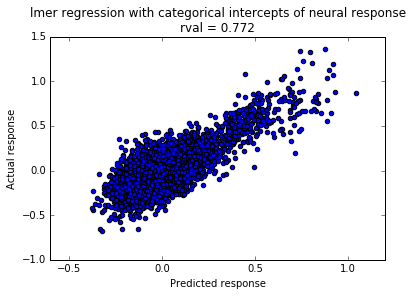

In [187]:
formula = ('n%d ~ (1 | category) + ' % num) + ' + '.join(['n%d' % d for d in pred_nums])
res = lme4.lmer(formula=formula, data=neural_data_frame)
preds = np.asarray(robjects.r.predict(res, data=neural_data_frame))
plt.scatter(preds, nd)
plt.xlabel('Predicted response')
plt.ylabel('Actual response')
rval = stats.pearsonr(preds, nd)[0]
plt.title('lmer regression with categorical intercepts of neural response\nrval = %.3f' % rval)

In [188]:
formula = ('n%d ~ (1 | category) + (1 + ' % num) + ' + '.join(['n%d' % d for d in pred_nums]) + ' | category)'
formula

'n183 ~ (1 | category) + (1 + n178 + n179 + n180 + n181 + n182 + n184 + n185 + n186 + n187 + n188| category)'

/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In commonArgs(par, fn, control, environment()) :
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:  maxfun < 10 * length(par)^2 is not recommended.

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In optwrap(optimizer, devfun, getStart(start, rho$lower, rho$pp),  :
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:  convergence code 1 from bobyqa: bobyqa -- maximum number of function evaluations exceeded

  warnings.warn(x, RRuntimeWarning)


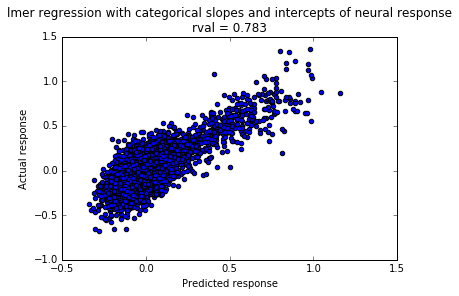

In [189]:
formula = ('n%d ~ (1 | category) + (1 + ' % num) + ' + '.join(['n%d' % d for d in pred_nums]) + '| category)'
res = lme4.lmer(formula=formula, data=neural_data_frame)
preds = np.asarray(robjects.r.predict(res, data=neural_data_frame))
plt.scatter(preds, nd)
plt.xlabel('Predicted response')
plt.ylabel('Actual response')
rval = stats.pearsonr(preds, nd)[0]
plt.title('lmer regression with categorical slopes and intercepts of neural response\nrval = %.3f' % rval)